In [6]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    confusion_matrix
)
import csv
np.random.seed(42)
random.seed(42)

BASE_PATH = 'dataset_split/discharge-notes/'
TRAIN_FILE = os.path.join(BASE_PATH, 'train.csv')
VAL_FILE = os.path.join(BASE_PATH, 'val.csv')
TEST_FILE = os.path.join(BASE_PATH, 'test.csv')

df_train = pd.read_csv(
    TRAIN_FILE,
    on_bad_lines='skip',
    quoting=csv.QUOTE_NONE,
    encoding='utf-8',
    engine='python'
)

print("1. Loading data...")

try:
    df_train = pd.read_csv(TRAIN_FILE)
    df_val = pd.read_csv(VAL_FILE)
    df_test = pd.read_csv(TEST_FILE)

    df_train_full = pd.concat([df_train, df_val], ignore_index=True)

except FileNotFoundError as e:
    print(f"\nERROR: File not found: {os.path.abspath(TRAIN_FILE).replace('train.csv', '...')}")
    raise

print(f"Train/Val samples: {len(df_train_full)}")
print(f"Test samples: {len(df_test)}")

REQUIRED_COLUMNS = ['chief_complaint', 'history_of_present_illness', 'major_surgical_procedure']
for col in REQUIRED_COLUMNS:
    if col not in df_train_full.columns or col not in df_test.columns:
        raise ValueError(f"ERROR: Missing column '{col}'")


# 2. FEATURE ENGINEERING
def create_text_feature(df):
    return df['chief_complaint'].fillna('') + " " + df['history_of_present_illness'].fillna('')

X_train = create_text_feature(df_train_full)
X_test = create_text_feature(df_test)

y_train_str = df_train_full['major_surgical_procedure'].fillna('UNKNOWN')
y_test_str = df_test['major_surgical_procedure'].fillna('UNKNOWN')

all_unique_labels = pd.concat([y_train_str, y_test_str]).unique()

le = LabelEncoder()
le.fit(all_unique_labels)

y_train = le.transform(y_train_str)
y_test = le.transform(y_test_str)

target_names = le.classes_
print(f"Number of classes: {len(target_names)}")
print(f"First 5 classes: {target_names[:5]}...")

print("2. Building Pipeline (TF-IDF + LinearSVC)...")
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words='english',
        min_df=5,
        max_features=50000
    )),
    ('clf', LinearSVC(
        C=1.0,
        class_weight='balanced',
        random_state=42
    )),
])

print("3. Training model...")
model_pipeline.fit(X_train, y_train)
print("Training complete.")
print("-" * 50)

print("4. Evaluating model on Test Set (Sklearn metrics)...")
y_pred = model_pipeline.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
test_f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n## Primary Results")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1-Macro: {test_f1_macro:.4f}")
print(f"F1-Weighted: {test_f1_weighted:.4f}")

print("\n## Classification Report")
if len(target_names) > 20:
    print(f"Warning: {len(target_names)} classes. Printing full report.")

print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
print("\n## Confusion Matrix (Shape)")
print(f"Matrix dimension: {cm.shape[0]} x {cm.shape[1]}")
print("Actual matrix should be included in your lab report.")
print("-" * 50)

print("5. CONCLUSION FOR LAB REPORT")
print(f"Classical model (TF-IDF + LinearSVC) achieved a Weighted F1-Score of {test_f1_weighted:.4f}.")
print("This result serves as a strong **benchmark** for comparison against SOTA Transformer models.")

1. Loading data...


ParserError: Error tokenizing data. C error: EOF inside string starting at row 98803

In [1]:
import pandas as pd
import numpy as np
import random
import os
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import csv

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

BASE_PATH = 'dataset_split/discharge-notes/'
TRAIN_FILE = os.path.join(BASE_PATH, 'train.csv')
VAL_FILE = os.path.join(BASE_PATH, 'val.csv')
TEST_FILE = os.path.join(BASE_PATH, 'test.csv')


print("1. Loading and Pre-processing data...")

try:
    df_train = pd.read_csv(TRAIN_FILE, engine="python", on_bad_lines="skip", quoting=csv.QUOTE_NONE)
    df_val = pd.read_csv(VAL_FILE, engine="python", on_bad_lines="skip", quoting=csv.QUOTE_NONE)
    df_test = pd.read_csv(TEST_FILE, engine="python", on_bad_lines="skip", quoting=csv.QUOTE_NONE)
    df_train_full = pd.concat([df_train, df_val], ignore_index=True)
except FileNotFoundError as e:
    print(f"\nERROR: File not found: {os.path.abspath(TRAIN_FILE).replace('train.csv', '...')}")
    raise

print(f"Train/Val samples: {len(df_train_full)}")
print(f"Test samples: {len(df_test)}")

REQUIRED_COLUMNS = ['chief_complaint', 'history_of_present_illness', 'major_surgical_procedure']
for col in REQUIRED_COLUMNS:
    if col not in df_train_full.columns or col not in df_test.columns:
        raise ValueError(f"ERROR: Missing column '{col}'")

def create_text_feature(df):
    return df['chief_complaint'].fillna('') + " " + df['history_of_present_illness'].fillna('')

X_train = create_text_feature(df_train_full)
X_test = create_text_feature(df_test)

y_train_str = df_train_full['major_surgical_procedure'].fillna('UNKNOWN')
y_test_str = df_test['major_surgical_procedure'].fillna('UNKNOWN')

TOP_K = 100
print(f"Filtering labels: Keeping Top {TOP_K} classes + 'OTHER_PROCEDURE'")

def clean_label(label):
    return ''.join(c.lower() if c.isalnum() or c.isspace() else '' for c in label).strip()

y_train_str_cleaned = y_train_str.apply(clean_label)
y_test_str_cleaned = y_test_str.apply(clean_label)

label_counts = y_train_str_cleaned.value_counts()
top_labels = label_counts.head(TOP_K).index.tolist()

def filter_labels(label, top_labels_list):
    if label in top_labels_list:
        return label
    return 'otherprocedure'

y_train_str_filtered = y_train_str_cleaned.apply(lambda x: filter_labels(x, top_labels))
y_test_str_filtered = y_test_str_cleaned.apply(lambda x: filter_labels(x, top_labels))

all_unique_labels_filtered = pd.concat([y_train_str_filtered, y_test_str_filtered]).unique()
le = LabelEncoder()
le.fit(all_unique_labels_filtered)

y_train = le.transform(y_train_str_filtered)
y_test = le.transform(y_test_str_filtered)

target_names = le.classes_
num_labels = len(target_names)
print(f"Numar final de clase: {num_labels}")

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {cls: w for cls, w in zip(np.unique(y_train), class_weights_array)}
class_weights_tensor = torch.from_numpy(class_weights_array.astype(np.float32))


MODEL_CHECKPOINT = 'roberta-base'
MAX_LENGTH = 512
BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 8

print(f"\n2. Incarcare Model: {MODEL_CHECKPOINT}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=num_labels,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

print("3. Conversie la formatul Hugging Face Dataset...")

train_data = pd.DataFrame({'text': X_train.tolist(), 'label': y_train.tolist()})
test_data = pd.DataFrame({'text': X_test.tolist(), 'label': y_test.tolist()})

raw_train_dataset = Dataset.from_pandas(train_data)
raw_test_dataset = Dataset.from_pandas(test_data)

tokenized_train_dataset = raw_train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = raw_test_dataset.map(tokenize_function, batched=True)

SAMPLE_SIZE = 50000
if len(tokenized_train_dataset) > SAMPLE_SIZE:
    print(f"Sampling set de antrenare la {SAMPLE_SIZE} mostre din {len(tokenized_train_dataset)}.")
    indices = np.random.choice(len(tokenized_train_dataset), SAMPLE_SIZE, replace=False)
    tokenized_train_dataset = tokenized_train_dataset.select(indices)
else:
    print("Nu se aplica sampling.")

tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["text"])

tokenized_train_dataset.set_format("torch")
tokenized_test_dataset.set_format("torch")

tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels")

class WeightedTrainer(Trainer):
   def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1_w = f1_score(labels, predictions, average="weighted", zero_division=0)
    return {"accuracy": acc, "f1_weighted": f1_w}

training_args = TrainingArguments(
    output_dir="./Roberta_results",
    num_train_epochs=1,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./Roberta_logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("\n4. Icepe Fine-Tuning cu RoBERTa-Base (1 Epoca, 50k mostre)...")
trainer.train()

print("\n5. Evaluare Finala (Pe Test Set):")
metrics = trainer.evaluate()
print(metrics)

print("\nAntrenare terminata. Metricele sunt disponibile în 'Roberta_logs'.")

/bigdata/userhome/students/md5_sd7aa1b0bd2cf032768f024455ba/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Loading and Pre-processing data...
Train/Val samples: 117170
Test samples: 11433
Filtering labels: Keeping Top 100 classes + 'OTHER_PROCEDURE'
Numar final de clase: 101

2. Incarcare Model: roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


3. Conversie la formatul Hugging Face Dataset...


Map: 100%|██████████| 11433/11433 [00:01<00:00, 6562.46 examples/s]
/tmp/ipykernel_289795/3325500235.py:168: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Sampling set de antrenare la 50000 mostre din 117170.

4. Icepe Fine-Tuning cu RoBERTa-Base (1 Epoca, 50k mostre)...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.859400,2.392112,0.866614,0.840578



5. Evaluare Finala (Pe Test Set):


{'eval_loss': 2.3921122550964355, 'eval_accuracy': 0.8666141870025366, 'eval_f1_weighted': 0.8405781242877209, 'eval_runtime': 181.1225, 'eval_samples_per_second': 63.123, 'eval_steps_per_second': 7.895, 'epoch': 1.0}

Antrenare terminata. Metricele sunt disponibile în 'Roberta_logs'.


/bigdata/userhome/students/md5_sd7aa1b0bd2cf032768f024455ba/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Incarcare date...
Train samples: 84566
Val samples:   32604
Test samples:  11433

2. Procesare Etichete...
Numar clase finale: 101

3. Tokenizare si Pregatire Dataset (Model: roberta-base)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 11433/11433 [00:01<00:00, 6532.11 examples/s]
/tmp/ipykernel_291659/743692930.py:161: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



4. Start Training (Full Dataset - This will take time)...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted
1,0.811000,0.077206,0.997301,0.996867
2,0.709800,0.052539,0.997608,0.997494
3,0.509300,0.048172,0.997730,0.997538



5. Evaluare Finala pe Test Set...


TEST ACCURACY: 0.8954
TEST F1 SCORE: 0.8843

Generare Matrice de Confuzie...


/tmp/ipykernel_291659/743692930.py:196: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Matricea de confuzie a fost salvata ca 'confusion_matrix.png'

6. Salvare Model Final...
Model salvat in './final_medical_model'. Gata de integrare!


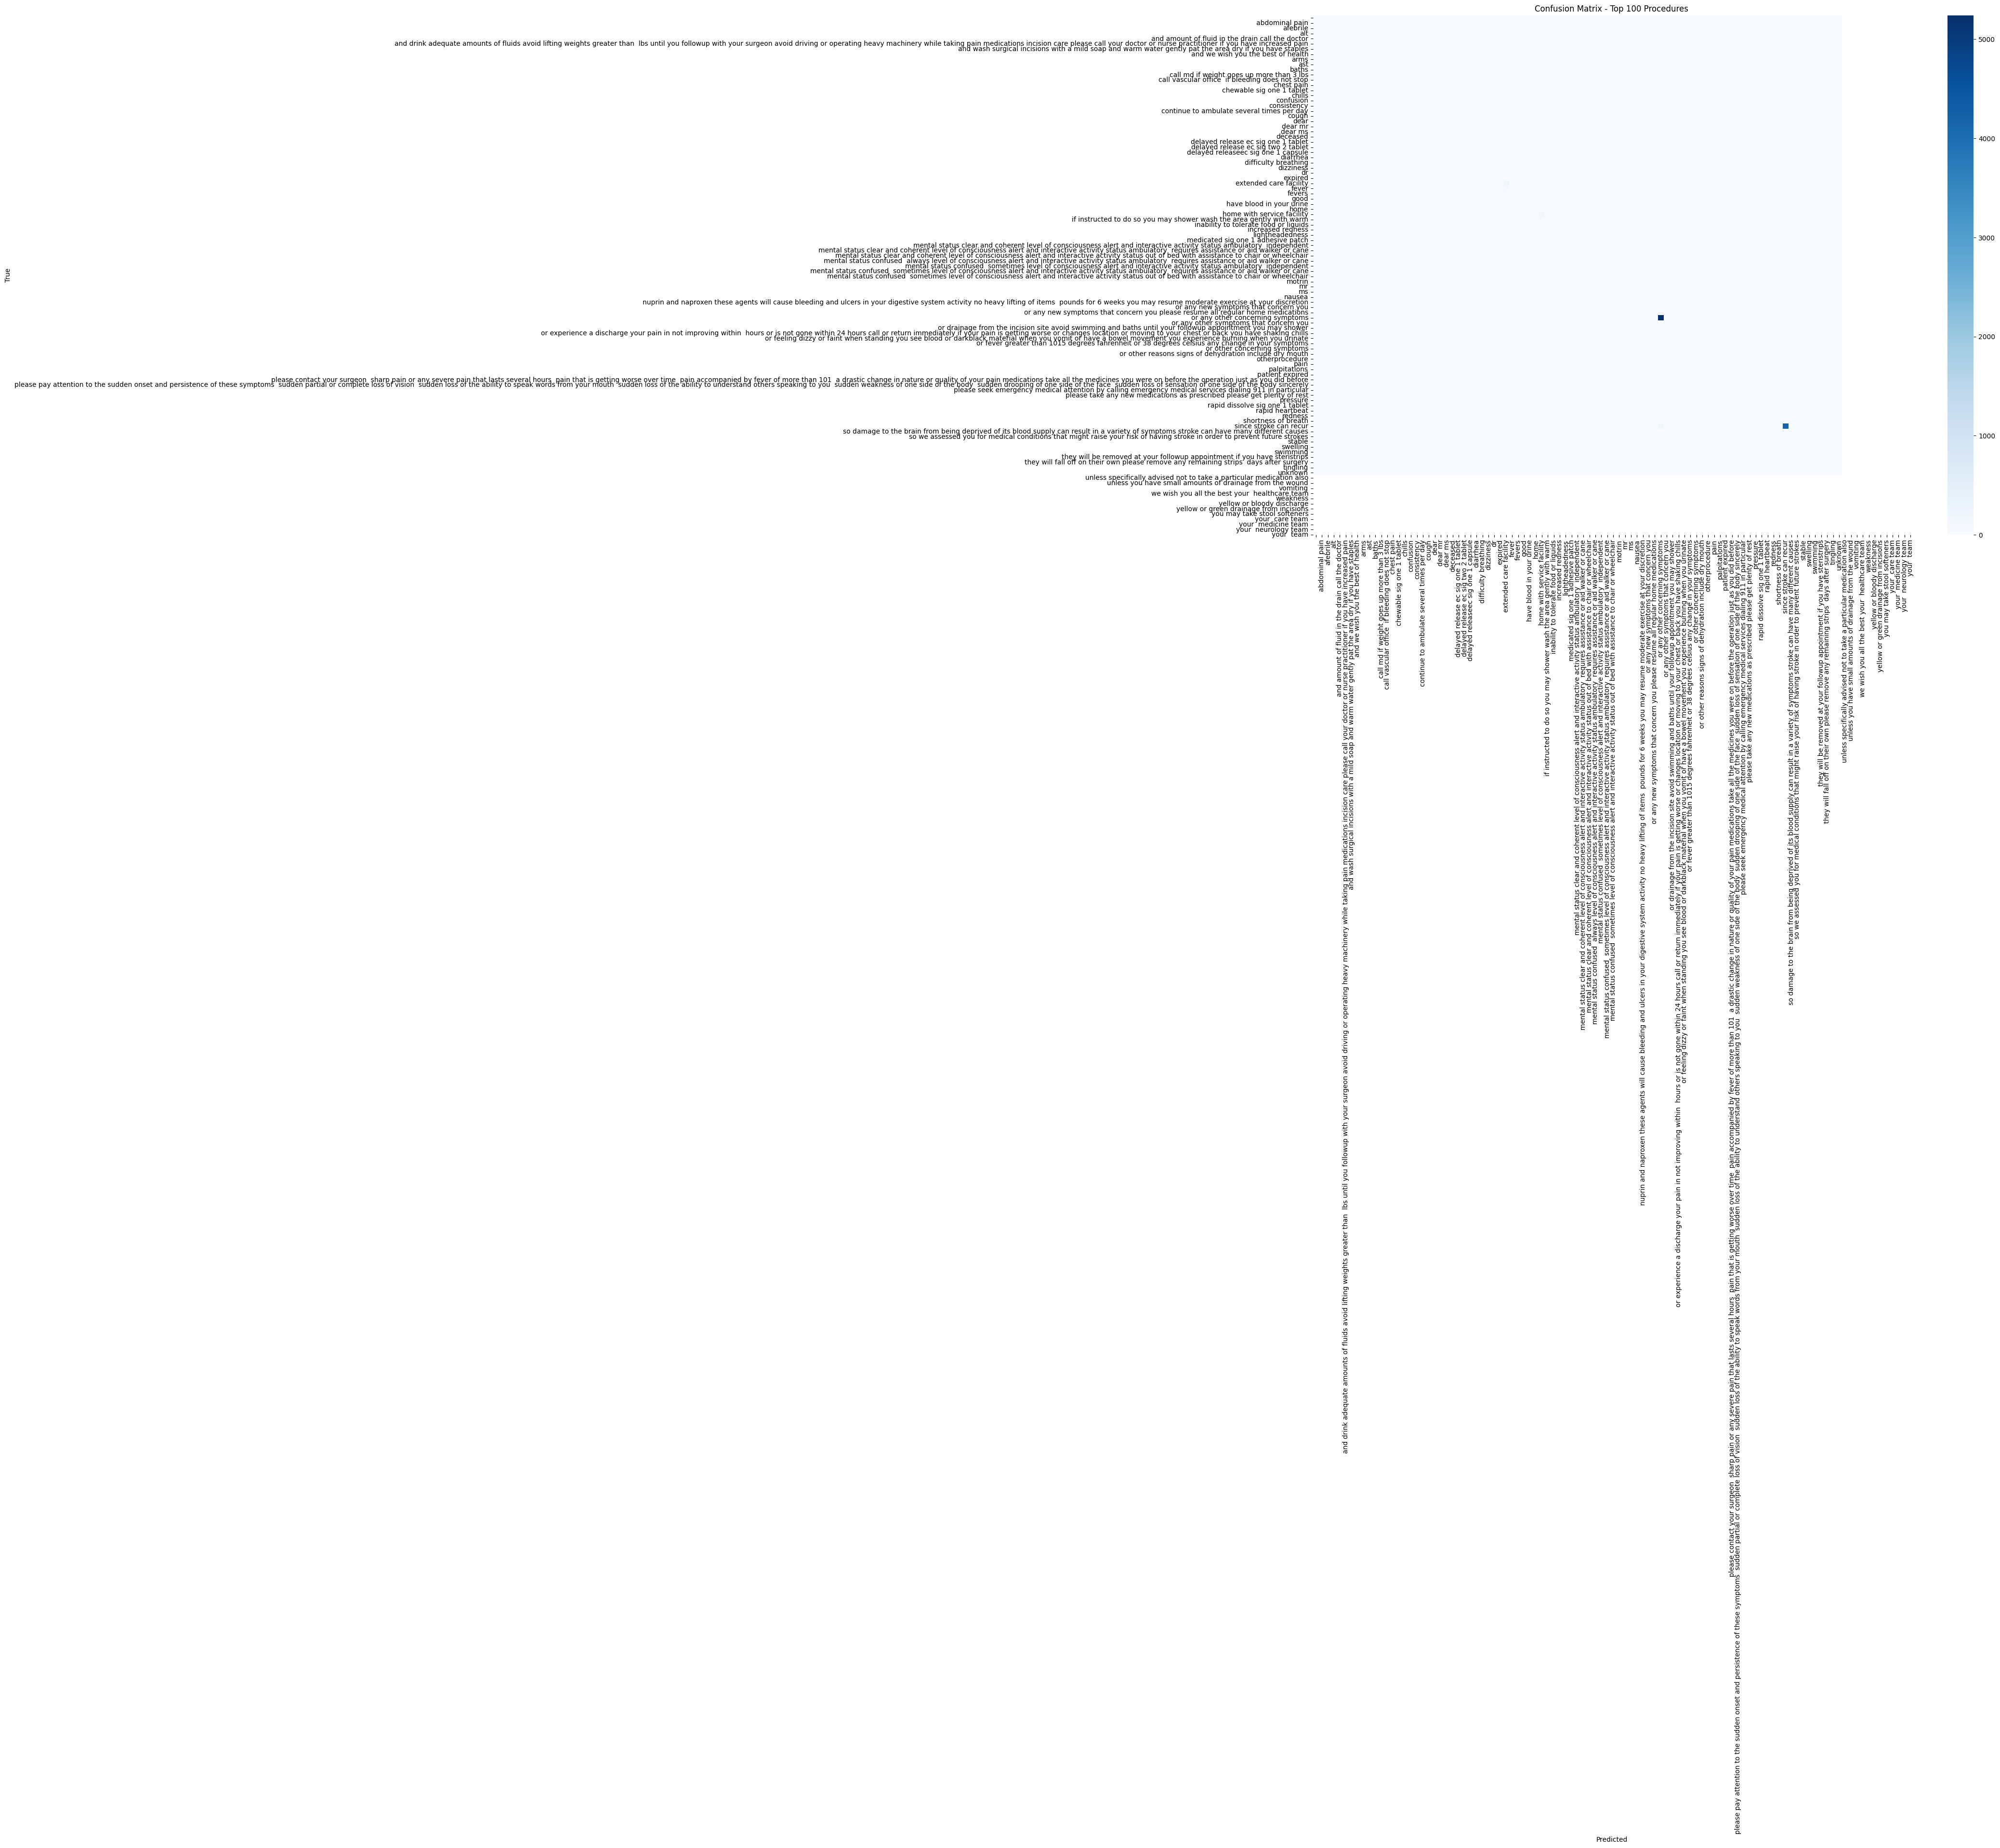

In [1]:
import pandas as pd
import numpy as np
import random
import os
import torch
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

BASE_PATH = 'dataset_split/discharge-notes/'
TRAIN_FILE = os.path.join(BASE_PATH, 'train.csv')
VAL_FILE = os.path.join(BASE_PATH, 'val.csv')
TEST_FILE = os.path.join(BASE_PATH, 'test.csv')

print("1. Incarcare date...")

df_train = pd.read_csv(TRAIN_FILE, engine="python", on_bad_lines="skip", quoting=csv.QUOTE_NONE)
df_val = pd.read_csv(VAL_FILE, engine="python", on_bad_lines="skip", quoting=csv.QUOTE_NONE)
df_test = pd.read_csv(TEST_FILE, engine="python", on_bad_lines="skip", quoting=csv.QUOTE_NONE)

print(f"Train samples: {len(df_train)}")
print(f"Val samples:   {len(df_val)}")
print(f"Test samples:  {len(df_test)}")

def create_text_feature(df):
    return df['chief_complaint'].fillna('') + " " + df['history_of_present_illness'].fillna('')

X_train = create_text_feature(df_train)
X_val = create_text_feature(df_val)
X_test = create_text_feature(df_test)

print("\n2. Procesare Etichete...")
y_train_str = df_train['major_surgical_procedure'].fillna('UNKNOWN')
y_val_str = df_val['major_surgical_procedure'].fillna('UNKNOWN')
y_test_str = df_test['major_surgical_procedure'].fillna('UNKNOWN')

TOP_K = 100
def clean_label(label):
    return ''.join(c.lower() if c.isalnum() or c.isspace() else '' for c in label).strip()

#curatare etichete
y_train_clean = y_train_str.apply(clean_label)
y_val_clean = y_val_str.apply(clean_label)
y_test_clean = y_test_str.apply(clean_label)

#top 100 clase din TRAIN
label_counts = y_train_clean.value_counts()
top_labels = label_counts.head(TOP_K).index.tolist()

def filter_labels(label, top_labels_list):
    if label in top_labels_list:
        return label
    return 'otherprocedure'

#filtrare
y_train_filtered = y_train_clean.apply(lambda x: filter_labels(x, top_labels))
y_val_filtered = y_val_clean.apply(lambda x: filter_labels(x, top_labels))
y_test_filtered = y_test_clean.apply(lambda x: filter_labels(x, top_labels))

le = LabelEncoder()
# fit pe train
all_labels = pd.concat([y_train_filtered, y_val_filtered, y_test_filtered]).unique()
le.fit(all_labels)

y_train = le.transform(y_train_filtered)
y_val = le.transform(y_val_filtered)
y_test = le.transform(y_test_filtered)

target_names = le.classes_
num_labels = len(target_names)
print(f"Numar clase finale: {num_labels}")

# greutate clase
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.from_numpy(class_weights_array.astype(np.float32))

#constante declarare model
MODEL_CHECKPOINT = 'roberta-base'
MAX_LENGTH = 512
BATCH_SIZE = 8
#pentru viteza
GRADIENT_ACCUMULATION_STEPS = 4

print(f"\n3. Tokenizare si Pregatire Dataset (Model: {MODEL_CHECKPOINT})...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=num_labels,
)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

# Creare Datasets HF
def create_hf_dataset(X, y):
    df = pd.DataFrame({'text': X.tolist(), 'labels': y.tolist()})
    ds = Dataset.from_pandas(df)
    ds = ds.map(tokenize_function, batched=True)
    ds = ds.remove_columns(["text"])
    ds.set_format("torch")
    return ds

train_dataset = create_hf_dataset(X_train, y_train)
val_dataset = create_hf_dataset(X_val, y_val)
test_dataset = create_hf_dataset(X_test, y_test)

#custom trainer pentru clasele weighted
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1_w = f1_score(labels, predictions, average="weighted", zero_division=0)
    return {"accuracy": acc, "f1_weighted": f1_w}

training_args = TrainingArguments(
    output_dir="./Roberta_Full_Model",
    num_train_epochs=3,              
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",           
    save_strategy="epoch",           
    load_best_model_at_end=True,     
    metric_for_best_model="f1_weighted",
    report_to="none"
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,       
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("\n4. Start Training (Full Dataset - This will take time)...")
trainer.train()

print("\n5. Evaluare Finala pe Test Set...")
predictions_output = trainer.predict(test_dataset)
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"TEST ACCURACY: {acc:.4f}")
print(f"TEST F1 SCORE: {f1:.4f}")

print("\nGenerare Matrice de Confuzie...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 14))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Top 100 Procedures')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Matricea de confuzie a fost salvata ca 'confusion_matrix.png'")

#salvare model dupa antrenare
print("\n6. Salvare Model Final...")
final_model_path = "./final_medical_model"
trainer.save_model(final_model_path)
#salvare label encoder-ul ca sa stim ce inseamna clasa 0, 1, 2...
import joblib
joblib.dump(le, os.path.join(final_model_path, "label_encoder.joblib"))

print(f"Model salvat in '{final_model_path}'. Gata de integrare!")